In [1]:
%%time
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn import cross_validation, ensemble, tree, metrics, preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
le = preprocessing.LabelEncoder()
import xgboost as xgb
from datetime import datetime, date
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

CPU times: user 1.22 s, sys: 501 ms, total: 1.72 s
Wall time: 3.96 s


In [2]:
%%time
temp_train_2014_1 = pd.read_csv('CAX_Train_2014_Jan_to_Jun.csv')
temp_train_2014_2 = pd.read_csv('CAX_Train_2014_Jul_to_Dec.csv')
temp_train_2015 = pd.read_csv('CAX_Train_2015.csv')
testing = pd.read_csv('CAX_TestSet.csv')
weather = pd.read_csv('weather.csv')
codes = pd.read_csv('training_weather_cities_joined.csv')

CPU times: user 51.5 s, sys: 9.78 s, total: 1min 1s
Wall time: 1min 2s


In [3]:
%%time
weather['week_of_year'] = pd.to_datetime(weather['date'], errors='coerce').dt.weekofyear.astype(int)
weather.events.fillna(-1, inplace=True)
weather.conditions.fillna(-1, inplace=True)
weather.gust_speed_mph.replace('-', -1, inplace=True)
weather.gust_speed_mph.fillna(-1, inplace=True)
weather.gust_speed_mph = pd.to_numeric(weather.gust_speed_mph, errors='coerce')
weather.wind_speed_mph.replace('Calm', 0, inplace=True)
weather.wind_speed_mph.fillna(-1, inplace=True)
weather.wind_speed_mph = pd.to_numeric(weather.wind_speed_mph, errors='coerce')
weather.events.replace(['Fog',
'Fog-Hail-Thunderstorm',
'Fog-Rain',
'Fog-Rain-Hail-Thunderstorm',
'Fog-Rain-Snow',
'Fog-Rain-Thunderstorm',
'Fog-Rain-Thunderstorm-Tornado',
'Fog-Snow',
'Fog-Snow-Thunderstorm',
'Fog-Thunderstorm',
'Hail',
'Hail-Thunderstorm',
'Rain',
'Rain-Hail',
'Rain-Hail-Thunderstorm',
'Rain-Snow',
'Rain-Snow-Thunderstorm',
'Rain-Thunderstorm',
'Rain-Thunderstorm-Tornado',
'Rain-Tornado',
'Snow',
'Snow-Hail',
'Snow-Thunderstorm',
'Snow-Tornado',
'Thunderstorm',
'Thunderstorm-Tornado',
'Tornado'], [10,
80,
20,
80,
60,
50,
100,
60,
60,
50,
80,
80,
20,
80,
80,
60,
60,
50,
100,
100,
60,
80,
60,
100,
50,
100,
100], inplace=True)
weather.conditions.replace(['Unknown',
'Clear',
'Overcast',
'Partly Cloudy',
'Drizzle',
'Scattered Clouds',
'Mostly Cloudy',
'Haze',
'Mist',
'Patches of Fog',
'Rain',
'Shallow Fog',
'Low Drifting Snow',
'Rain Showers',
'Light Blowing Snow',
'Light Drizzle',
'Light Fog',
'Light Hail',
'Light Ice Pellets',
'Light Low Drifting Snow',
'Light Mist',
'Light Rain',
'Light Rain Showers',
'Light Sand',
'Light Small Hail Showers',
'Light Smoke',
'Light Snow',
'Light Snow Grains',
'Light Snow Showers',
'Light Thunderstorm',
'Light Thunderstorms and Rain',
'Light Thunderstorms and Snow',
'Light Thunderstorms with Hail',
'Light Thunderstorms with Small Hail',
'Heavy Blowing Snow',
'Heavy Drizzle',
'Heavy Freezing Drizzle',
'Heavy Freezing Fog',
'Heavy Freezing Rain',
'Heavy Ice Pellets',
'Heavy Rain',
'Heavy Rain Showers',
'Heavy Small Hail',
'Heavy Snow',
'Heavy Snow Showers',
'Heavy Thunderstorm',
'Heavy Thunderstorms and Rain',
'Heavy Thunderstorms and Snow',
'Heavy Thunderstorms with Hail',
'Heavy Thunderstorms with Small Hail',
'Ice Crystals',
'Ice Pellets',
'Funnel Cloud',
'Blowing Sand',
'Blowing Snow',
'Thunderstorm',
'Thunderstorms and Rain',
'Thunderstorms and Snow',
'Thunderstorms with Hail',
'Thunderstorms with Small Hail',
'Volcanic Ash',
'Widespread Dust',
'Sand',
'Sandstorm',
'Small Hail',
'Small Hail Showers',
'Smoke',
'Snow',
'Snow Grains',
'Snow Showers',
'Squalls',
'Fog',
'Freezing Rain',
'Hail',
'Light Freezing Drizzle',
'Light Freezing Fog',
'Light Freezing Rain'], [-1,
0,
0,
0,
10,
0,
0,
0,
0,
10,
10,
10,
30,
10,
30,
10,
10,
50,
70,
30,
0,
10,
10,
30,
50,
20,
30,
70,
30,
20,
20,
40,
60,
60,
80,
20,
70,
70,
90,
80,
20,
20,
70,
80,
80,
50,
30,
80,
80,
80,
70,
70,
90,
70,
70,
40,
30,
70,
80,
80,
100,
20,
60,
80,
60,
70,
20,
60,
60,
60,
70,
10,
80,
50,
60,
50,
80], inplace=True)

CPU times: user 58.2 s, sys: 4.95 s, total: 1min 3s
Wall time: 1min 3s


In [4]:
%%time
weather_group = weather.groupby( [ 'airport_code', 'week_of_year'] ).mean()
weather_group = weather_group.reset_index()
weather_group = weather_group.drop('zip', 1)
weather_group.fillna(-1, inplace=True)

CPU times: user 1.88 s, sys: 1.59 s, total: 3.47 s
Wall time: 3.76 s


In [5]:
%%time
# this array defines the dates of holiday in 2007 and 2008
holidays = [
        date(2014, 1, 1), date(2014, 1, 20), date(2014, 5, 26), date(2014, 7, 4), \
        date(2014, 9, 1), date(2014, 11, 27), date(2014, 12, 25), \
        date(2015, 1, 1), date(2015, 1, 19), date(2015, 5, 25), date(2015, 7, 4), \
        date(2015, 9, 7), date(2015, 11, 26), date(2015, 12, 25) \
     ]

def days_from_nearest_holiday(year, month, day):
  d = date(year, month, day)
  x = [(abs(d-h)).days for h in holidays]
  return min(x)

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 12.2 µs


In [6]:
%%time
testing = pd.merge(testing, codes[['ORIGIN', 'city', 'airport_code']], left_on='ORIGIN', right_on='ORIGIN')
testing.rename(columns={'city': 'origin_city', 'airport_code': 'origin_icao_code'}, inplace=True)
testing = pd.merge(testing, codes[['ORIGIN', 'city', 'airport_code']], left_on='DEST', right_on='ORIGIN')
testing.rename(columns={'city': 'dest_city', 'airport_code': 'dest_icao_code', 'ORIGIN_x': 'ORIGIN'}, inplace=True)
testing = testing.drop('ORIGIN_y', 1)
testing['DAY_OF_YEAR'] = pd.to_datetime(testing['FL_DATE'], errors='coerce').dt.dayofyear.astype(int)
testing['WEEK_OF_YEAR'] = pd.to_datetime(testing['FL_DATE'], errors='coerce').dt.weekofyear.astype(int)
testing['day'] = pd.to_datetime(testing['FL_DATE'], errors='coerce').dt.day.astype(int)
testing['hour'] = testing['CRS_DEP_TIME'].map(lambda x: int(str(int(x)).zfill(4)[:2]))
testing['days_from_holidays'] = [days_from_nearest_holiday(r.YEAR, r.MONTH, r.day) for i,r in testing.iterrows()]
testing = pd.merge(testing, weather_group, left_on=['origin_icao_code', 'WEEK_OF_YEAR'], right_on=['airport_code', 'week_of_year'], how='left')
testing.rename(columns={'conditions': 'orig_conditions', 'airport_code': 'orig_airport_code', 'week_of_year': 'orig_week_of_year', 'temperature_f': 'orig_temperature_f', 'dew_point_f': 'orig_dew_point_f', 'humidity': 'orig_humidity', 'sea_level_pressure_in': 'orig_sea_level_pressure_in', 'visibility_mph': 'orig_visibility_mph', 'wind_speed_mph': 'orig_wind_speed_mph', 'gust_speed_mph': 'orig_gust_speed_mph', 'precipitation_in': 'orig_precipitation_in', 'events': 'orig_events', 'wind_dir_degrees': 'orig_wind_dir_degrees'}, inplace=True)
testing = pd.merge(testing, weather_group, left_on=['dest_icao_code', 'WEEK_OF_YEAR'], right_on=['airport_code', 'week_of_year'], how='left')
testing.rename(columns={'conditions': 'dest_conditions', 'airport_code': 'dest_airport_code', 'week_of_year': 'dest_week_of_year', 'temperature_f': 'dest_temperature_f', 'dew_point_f': 'dest_dew_point_f', 'humidity': 'dest_humidity', 'sea_level_pressure_in': 'dest_sea_level_pressure_in', 'visibility_mph': 'dest_visibility_mph', 'wind_speed_mph': 'dest_wind_speed_mph', 'gust_speed_mph': 'dest_gust_speed_mph', 'precipitation_in': 'dest_precipitation_in', 'events': 'dest_events', 'wind_dir_degrees': 'dest_wind_dir_degrees'}, inplace=True)
testing.fillna(-1, inplace=True)

CPU times: user 2min 44s, sys: 8.71 s, total: 2min 52s
Wall time: 2min 53s


In [7]:
%%time
training = pd.concat([temp_train_2014_1, temp_train_2014_2, temp_train_2015], ignore_index=True)
training = pd.merge(training, codes[['ORIGIN', 'city', 'airport_code']], left_on='ORIGIN', right_on='ORIGIN')
training.rename(columns={'city': 'origin_city', 'airport_code': 'origin_icao_code'}, inplace=True)
training = pd.merge(training, codes[['ORIGIN', 'city', 'airport_code']], left_on='DEST', right_on='ORIGIN')
training.rename(columns={'city': 'dest_city', 'airport_code': 'dest_icao_code', 'ORIGIN_x': 'ORIGIN'}, inplace=True)
training = training.drop('ORIGIN_y', 1)
training['DAY_OF_YEAR'] = pd.to_datetime(training['FL_DATE'], errors='coerce').dt.dayofyear.astype(int)
training['WEEK_OF_YEAR'] = pd.to_datetime(training['FL_DATE'], errors='coerce').dt.weekofyear.astype(int)
training['hour'] = training['CRS_DEP_TIME'].map(lambda x: int(str(int(x)).zfill(4)[:2]))
training['day'] = pd.to_datetime(training['FL_DATE'], errors='coerce').dt.day.astype(int)
training['days_from_holidays'] = [days_from_nearest_holiday(r.YEAR, r.MONTH, r.day) for i,r in training.iterrows()]
training = pd.merge(training, weather_group, left_on=['origin_icao_code', 'WEEK_OF_YEAR'], right_on=['airport_code', 'week_of_year'], how='left')
training.rename(columns={'conditions': 'orig_conditions', 'airport_code': 'orig_airport_code', 'week_of_year': 'orig_week_of_year', 'temperature_f': 'orig_temperature_f', 'dew_point_f': 'orig_dew_point_f', 'humidity': 'orig_humidity', 'sea_level_pressure_in': 'orig_sea_level_pressure_in', 'visibility_mph': 'orig_visibility_mph', 'wind_speed_mph': 'orig_wind_speed_mph', 'gust_speed_mph': 'orig_gust_speed_mph', 'precipitation_in': 'orig_precipitation_in', 'events': 'orig_events', 'wind_dir_degrees': 'orig_wind_dir_degrees'}, inplace=True)
training = pd.merge(training, weather_group, left_on=['dest_icao_code', 'WEEK_OF_YEAR'], right_on=['airport_code', 'week_of_year'], how='left')
training.rename(columns={'conditions': 'dest_conditions', 'airport_code': 'dest_airport_code', 'week_of_year': 'dest_week_of_year', 'temperature_f': 'dest_temperature_f', 'dew_point_f': 'dest_dew_point_f', 'humidity': 'dest_humidity', 'sea_level_pressure_in': 'dest_sea_level_pressure_in', 'visibility_mph': 'dest_visibility_mph', 'wind_speed_mph': 'dest_wind_speed_mph', 'gust_speed_mph': 'dest_gust_speed_mph', 'precipitation_in': 'dest_precipitation_in', 'events': 'dest_events', 'wind_dir_degrees': 'dest_wind_dir_degrees'}, inplace=True)
training.fillna(-1, inplace=True)

CPU times: user 16min 53s, sys: 1min 46s, total: 18min 40s
Wall time: 19min 29s


In [8]:
%%time
features = [c for c in training.columns if c in ['days_from_holidays', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DISTANCE', 'hour', 'orig_temperature_f', 'orig_dew_point_f', 'orig_humidity', 'orig_sea_level_pressure_in', 'orig_visibility_mph', 'orig_wind_speed_mph', 'orig_gust_speed_mph', 'orig_precipitation_in', 'orig_events', 'orig_conditions', 'orig_wind_dir_degrees', 'dest_temperature_f', 'dest_dew_point_f', 'dest_humidity', 'dest_sea_level_pressure_in', 'dest_visibility_mph', 'dest_wind_speed_mph', 'dest_gust_speed_mph', 'dest_precipitation_in', 'dest_events', 'dest_conditions', 'dest_wind_dir_degrees']]

CPU times: user 136 µs, sys: 45 µs, total: 181 µs
Wall time: 165 µs


In [9]:
%%time
print len(training)
columns = ['DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'hour']
for i in columns:
    mask = training[i].isin(list(testing[i].drop_duplicates().values))
    training = training[mask]
#     difference = [c for c in list(test_training[i].drop_duplicates().values) if c not in list(test_testing[i].drop_duplicates().values)]
#     print i, difference, len(test_training[i].drop_duplicates()), len(test_testing[i].drop_duplicates())
print len(training)

8496931
7796102
CPU times: user 25.7 s, sys: 50.1 s, total: 1min 15s
Wall time: 1min 40s


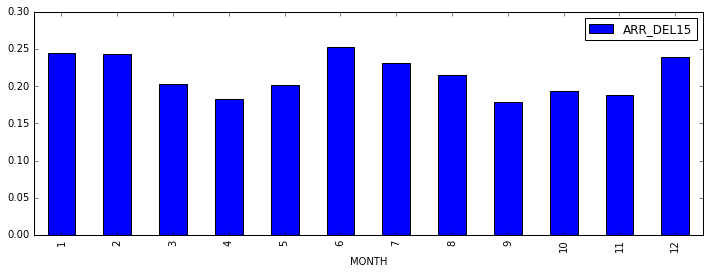

In [10]:
# Select a Pandas dataframe with flight originating from ORD

# Compute average number of delayed flights per month
grouped = training[['ARR_DEL15', 'MONTH']].groupby('MONTH').mean()

# plot average delays by month
grouped.plot(kind='bar')

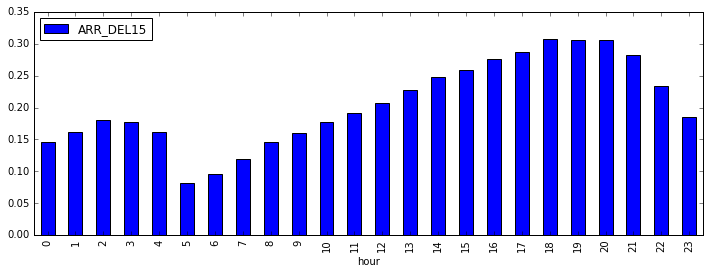

In [11]:
# Compute average number of delayed flights by hour
grouped = training[['ARR_DEL15', 'hour']].groupby('hour').mean()

# plot average delays by hour of day
grouped.plot(kind='bar')

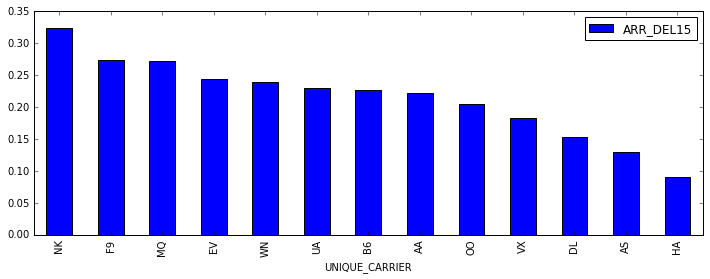

In [12]:
# Compute average number of delayed flights per carrier
grouped1 = training[['ARR_DEL15', 'UNIQUE_CARRIER']].groupby('UNIQUE_CARRIER').filter(lambda x: len(x)>10)
grouped2 = grouped1.groupby('UNIQUE_CARRIER').mean()
carrier = grouped2.sort(['ARR_DEL15'], ascending=False)

# display top 15 destination carriers by delay (from ORD)
carrier.plot(kind='bar')

In [13]:
%%time
delayed = training[training['ARR_DEL15'] == 1]
on_time = training[training['ARR_DEL15'] == 0]
sample_rows = np.random.choice(on_time.index.values, (len(delayed)))
on_time = on_time.ix[sample_rows]
training = pd.concat([on_time, delayed], ignore_index=True)

CPU times: user 24.3 s, sys: 26.9 s, total: 51.1 s
Wall time: 1min 13s


In [ ]:
# print (pd.to_datetime(training['FL_DATE'], errors='coerce').min()), (pd.to_datetime(training['FL_DATE'], errors='coerce').max())
# print (pd.to_datetime(testing['FL_DATE'], errors='coerce').min()), (pd.to_datetime(testing['FL_DATE'], errors='coerce').max())
# print (pd.to_datetime(weather['date'], errors='coerce').min()), (pd.to_datetime(weather['date'], errors='coerce').max())

In [14]:
%%time
training.UNIQUE_CARRIER = le.fit_transform(training.UNIQUE_CARRIER)
training.ORIGIN = le.fit_transform(training.ORIGIN)
training.DEST = le.fit_transform(training.DEST)

CPU times: user 11.6 s, sys: 625 ms, total: 12.2 s
Wall time: 12.5 s


In [15]:
%%time
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(training[features], training['ARR_DEL15'], test_size=0.50)
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features_train, labels_train, test_size=0.40)
# features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features_train, labels_train, test_size=0.40)

CPU times: user 9.8 s, sys: 9 s, total: 18.8 s
Wall time: 24.7 s


In [ ]:
%%time
categ = [list(features_train.columns).index(x) for x in 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'hour']
enc = OneHotEncoder(categorical_features = categ)
features_train['UNIQUE_CARRIER'] = pd.factorize(features_train['UNIQUE_CARRIER'])[0]
features_train['ORIGIN'] = pd.factorize(features_train['ORIGIN'])[0]
features_train['DEST'] = pd.factorize(features_train['DEST'])[0]
features_train = enc.fit_transform(features_train)

features_test['UNIQUE_CARRIER'] = pd.factorize(features_test['UNIQUE_CARRIER'])[0]
features_test['ORIGIN'] = pd.factorize(features_test['ORIGIN'])[0]
features_test['DEST'] = pd.factorize(features_test['DEST'])[0]
features_test = enc.transform(features_test)

print features_train.shape

In [ ]:
%%time
# features_test['UNIQUE_CARRIER'] = pd.factorize(features_test['UNIQUE_CARRIER'])[0]
# features_test['ORIGIN'] = pd.factorize(features_test['ORIGIN'])[0]
# features_test['DEST'] = pd.factorize(features_test['DEST'])[0]
# features_test['origin_icao_code'] = pd.factorize(features_test['origin_icao_code'])[0]
# features_test['dest_icao_code'] = pd.factorize(features_test['dest_icao_code'])[0]
# features_test = enc.transform(features_test)

testing['UNIQUE_CARRIER'] = pd.factorize(testing['UNIQUE_CARRIER'])[0]
testing['ORIGIN'] = pd.factorize(testing['ORIGIN'])[0]
testing['DEST'] = pd.factorize(testing['DEST'])[0]
testing_trans = enc.transform(testing[features])
print testing_trans.shape

In [18]:
%%time
def modelfit(alg, features, labels, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(features.values, label=labels.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=['auc'], early_stopping_rounds=early_stopping_rounds, show_progress=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(features, labels, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(features)
    dtrain_predprob = alg.predict_proba(features)[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(labels.values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(labels, dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

CPU times: user 5 µs, sys: 8 µs, total: 13 µs
Wall time: 42.2 µs


In [17]:
%%time
xgb1 = xgb.XGBClassifier(
 learning_rate = 1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, features_train, labels_train)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-auc:0.622138+0.02697195043	cv-train-auc:0.623945+0.0259324766345
[1]	cv-test-auc:0.6565948+0.00205542301242	cv-train-auc:0.6577216+0.00134319776653
[2]	cv-test-auc:0.6635022+0.00201267855357	cv-train-auc:0.665282+0.00158719677419
[3]	cv-test-auc:0.667217+0.00230531169259	cv-train-auc:0.6691986+0.00204247669265
[4]	cv-test-auc:0.671516+0.00172251432505	cv-train-auc:0.6736814+0.00181216827033
[5]	cv-test-auc:0.674305+0.00142369800168	cv-train-auc:0.6769146+0.00159971667491
[6]	cv-test-auc:0.6774+0.0012654986369	cv-train-auc:0.6801236+0.00104823348544
[7]	cv-test-auc:0.6795204+0.000801512220743	cv-train-auc:0.6826098+0.0010208334634
[8]	cv-test-auc:0.6818394+0.000682329421907	cv-train-auc:0.685339+0.000927868956265
[9]	cv-test-auc:0.6835532+0.000598389304717	cv-train-auc:0.6875074+0.000632742791346
[10]	cv-test-auc:0.685106+0.000880833014822	cv-train-auc:0.6892022+0.000337478532651
[11]	cv-test-auc:0.6861444+0.0009521282

KeyboardInterrupt: 

In [19]:
%%time
xgb_final =  xgb.XGBClassifier(
 learning_rate = 1,
 n_estimators=205,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27).fit(features_train.values, labels_train.values)

CPU times: user 12min 36s, sys: 6.14 s, total: 12min 42s
Wall time: 12min 56s


In [64]:
%%time
param_test1 = {
# 'min_samples_split':range(10,50,10),
 'min_samples_split':[70,80,90],
}
gsearch1 = GridSearchCV(estimator = ensemble.RandomForestClassifier(n_estimators=10), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False,cv=5)
gsearch1.fit(features_train, labels_train)
print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

[mean: 0.70143, std: 0.00078, params: {'min_samples_split': 70}, mean: 0.70118, std: 0.00108, params: {'min_samples_split': 80}, mean: 0.70216, std: 0.00067, params: {'min_samples_split': 90}] {'min_samples_split': 90} 0.702161722827
CPU times: user 1min 30s, sys: 3.09 s, total: 1min 33s
Wall time: 8min 29s


In [65]:
%%time
#d_tree = tree.DecisionTreeClassifier(min_samples_split=1000).fit(features_train, labels_train)
# Best so far: clf_rf = ensemble.RandomForestClassifier(n_estimators=50, n_jobs=-1, min_samples_split=50).fit(features_train, labels_train)
clf_rf = ensemble.RandomForestClassifier(n_estimators=50, n_jobs=-1, min_samples_split=90).fit(features_train, labels_train)

CPU times: user 9min 45s, sys: 5.04 s, total: 9min 50s
Wall time: 2min 52s


In [66]:
%%time
# Evaluate on test set
#pred = xgb_final.predict(features_test)
#pred = d_tree.predict(features_test)
pred = clf_rf.predict(features_test)

# print results
cm = confusion_matrix(labels_test, pred)
print("Confusion matrix")
print(pd.DataFrame(cm))

report_rf = precision_recall_fscore_support(list(labels_test), list(pred), average='micro')
print "precision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_rf[0], report_rf[1], report_rf[2], metrics.roc_auc_score(list(labels_test.values), list(pred)))

Confusion matrix
        0       1
0  221081  116055
1  113502  224297


/Users/arkham/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


precision = 0.66, recall = 0.66, F1 = 0.66, accuracy = 0.66

CPU times: user 16.9 s, sys: 885 ms, total: 17.8 s
Wall time: 6.41 s


In [22]:
%%time
testing.UNIQUE_CARRIER = le.fit_transform(testing.UNIQUE_CARRIER)
testing.ORIGIN = le.fit_transform(testing.ORIGIN)
testing.DEST = le.fit_transform(testing.DEST)

CPU times: user 3.49 s, sys: 780 ms, total: 4.27 s
Wall time: 5.03 s


In [67]:
%%time
#test_pred = xgb_final.predict(testing[features])
test_pred = clf_rf.predict(testing[features])

CPU times: user 16.6 s, sys: 1.64 s, total: 18.3 s
Wall time: 6.2 s


In [68]:
%%time
submission = pd.DataFrame()
submission['id'] = testing['id']
submission['ARR_DEL15'] = test_pred

CPU times: user 91 ms, sys: 63.5 ms, total: 155 ms
Wall time: 167 ms


In [69]:
%%time
submission.to_csv('submission.csv', index=False)

CPU times: user 1.33 s, sys: 37.2 ms, total: 1.37 s
Wall time: 1.47 s


In [ ]:
%%time
# Create Random Forest classifier with 100 trees
clf_rf = ensemble.RandomForestClassifier(n_estimators=50, n_jobs=-1)
clf_rf.fit(features_train.toarray(), labels_train)

In [ ]:
%%time
# Evaluate on test set
pred = clf_rf.predict(features_test.toarray())

# print results
cm = confusion_matrix(labels_test, pr)
print("Confusion matrix")
print(pd.DataFrame(cm))

report_rf = precision_recall_fscore_support(list(labels_test), list(pr), average='micro')
print "precision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_rf[0], report_rf[1], report_rf[2], metrics.roc_auc_score(list(labels_test.values), list(pred)))

In [ ]:
%%time
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate=1, n_estimators=242, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(features_train, labels_train.values)
print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
%%time
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate=1, n_estimators=81, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(features_train.values, labels_train.values)
print gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
%%time
param_test2b = {
 'min_child_weight':[6,7,8]
}
gsearch2b = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate=1, n_estimators=110, max_depth=4,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(features_train.values, labels_train.values)
print gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate=1, n_estimators=110, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(features_train.values, labels_train.values)
print gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
%%time
xgb2 = xgb.XGBClassifier(
 learning_rate =1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, features_train, labels_train)

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=1, n_estimators=255, max_depth=4,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(features_train.values, labels_train.values)
print gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
param_test5 = {
 'subsample':[i/100.0 for i in range(85,95,5)],
 'colsample_bytree':[i/100.0 for i in range(75,85,5)]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=1, n_estimators=158, max_depth=5,
 min_child_weight=2, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(features_train.values, labels_train.values)
print gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

In [ ]:
%%time
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=1, n_estimators=158, max_depth=5,
 min_child_weight=2, gamma=0.1, subsample=0.9, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(features_train.values, labels_train.values)
print gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
%%time
param_test7 = {
 'reg_alpha':[0.9, 0.95, 1, 1.05, 1.1]
}

gsearch7 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=1, n_estimators=158, max_depth=5,
 min_child_weight=2, gamma=0.1, subsample=0.9, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(features_train.values, labels_train.values)
print gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

In [ ]:
%%time
xgb3 = xgb.XGBClassifier(
 learning_rate=1,
 n_estimators=1000,
 max_depth=5,
 reg_alpha=100,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, features_train, labels_train)

In [ ]:
%%time
xgb4 = xgb.XGBClassifier(
 learning_rate=.5,
 n_estimators=5000,
 max_depth=5,
 reg_alpha=100,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, features_train, labels_train)

In [ ]:
test_hour = [str((i/100) * 100) if (i % 100) < 50 else str((i/100) * 100 + 100) for i in training['CRS_DEP_TIME'].values]

In [ ]:
%%time
training['DEP_HOUR'] = [str((i/100) * 100) if (i % 100) < 30 else str((i/100) * 100 + 100) for i in training['CRS_DEP_TIME'].values]
training['ARR_HOUR'] = [str((i/100) * 100) if (i % 100) < 30 else str((i/100) * 100 + 100) for i in training['CRS_ARR_TIME'].values]